### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import _LRScheduler
from IPython.display import clear_output
from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchmetrics.image.fid import FrechetInceptionDistance

print('imported')

imported


### Constants

In [2]:
np.random.seed(42)

DATA_DIR = './data/'
WEIGHT_DIR = './weights/'
STATS_DIR = './stats/'

# creating main paths
if not os.path.exists(WEIGHT_DIR):
    os.mkdir(WEIGHT_DIR)
if not os.path.exists(STATS_DIR):
    os.mkdir(STATS_DIR)

# working device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Selected device: {}'.format(device))
print('Device name: {}'.format(torch.cuda.get_device_name(device)))

# other cosntants
# you can modify from here: and only modify whats possible to modify (for backbones and optimizers)
DATASET = 'mnist'
assert DATASET in ['mnist', 'cifar10', 'brats'], 'Choose an available dataset'
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = (128, 128) if DATASET == 'brats' else (32, 32)
LEARNING_RATE = 0.01
LATENT_DIM = 4
IN_CHANNELS = 1
NUM_CHANNELS = 256
BOTTLENECK_RATIO = 0.5

Selected device: cuda
Device name: NVIDIA RTX A6000


## Data preprocessing

### MNIST

In [3]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, x, transform=None):
        self.x = x
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.x[idx])
        return self.x[idx]

# dans un premier lieu, nous allons travailler avec MNIST
mnist = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True)

n_samples = 1000

# removing some digits to reduce the size of the dataset
selected_index = np.isin(mnist.targets, [1, 2, 3])
images = mnist.data[selected_index][:n_samples]
targets = mnist.targets[selected_index][:n_samples]

# preprocessing
images = images.div(255).type(torch.float32)
images = images.unsqueeze(1)

train_x, test_x, train_y, test_y = train_test_split(images, targets, test_size=0.1, random_state=42)

print('Number of training samples: {}'.format(len(train_x)))
print('Number of test samples: {}'.format(len(test_x)))
print('Number of iterations per epoch: {}'.format(len(train_x // BATCH_SIZE)))
print('Image size: {}'.format(train_x.shape))
print('Image max value: {}'.format(train_x.max()))
print('Image min value: {}'.format(train_x.min()))

Number of training samples: 900
Number of test samples: 100
Number of iterations per epoch: 900
Image size: torch.Size([900, 1, 28, 28])
Image max value: 1.0
Image min value: 0.0


### BraTS

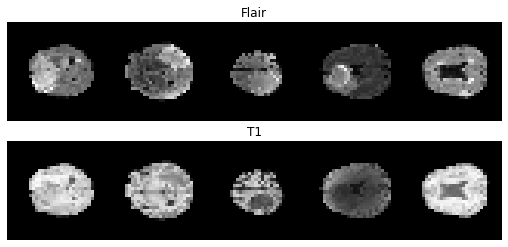

Number of training samples: 900
Number of test samples: 100
Image size: torch.Size([32, 32])
Total shape: torch.Size([900, 1, 32, 32])
Max pixel value: 0.9964683055877686
Min pixel value: 0.0


In [4]:
# loading brats dataset
data = np.load(os.path.join(DATA_DIR, 'brats_data.npz'))
flair, t1 = data['flair'], data['t1']


# preprocessing
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1 = [t1[i].max() for i in range(t1.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1[idx] = (t1[idx] / n_max_t1[idx]).astype(np.float32)

flair = torch.tensor(flair, dtype=torch.float32).unsqueeze(1)
t1 = torch.tensor(t1, dtype=torch.float32).unsqueeze(1)

# resize images
if IMG_SIZE != flair.shape[2:]:
    flair = T.functional.resize(flair, IMG_SIZE)
    t1 = T.functional.resize(t1, IMG_SIZE)

# splitting dataset
n_train = int(0.9 * flair.shape[0])
flair_train_x, flair_test_x = flair[:n_train], flair[n_train:]
t1_train_x, t1_test_x = t1[:n_train], t1[n_train:]

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, flair_train_x.shape[0], n_to_visualize)

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(np.hstack([flair_train_x[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('Flair')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(np.hstack([t1_train_x[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('T1')
plt.axis('off')

plt.show()

print('Number of training samples: {}'.format(flair_train_x.shape[0]))
print('Number of test samples: {}'.format(flair_test_x.shape[0]))
print('Image size: {}'.format(flair_train_x.shape[2:]))
print('Total shape: {}'.format(flair_train_x.shape))
print('Max pixel value: {}'.format(flair.max()))
print('Min pixel value: {}'.format(flair.min()))

### Utilities

In [5]:
# norm
normalize = lambda x: x / 255.0
denormalize = lambda x: x * 255.0

def save_image(img, filename):
    plt.figure(figsize=(25, 25))        
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(img[i].squeeze(0).detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.savefig(os.path.join(STATS_DIR, filename), bbox_inches='tight', pad_inches=0)

def sample_and_save(model, **kwargs):
    model.eval()
    with torch.no_grad():
        g = model.sample(100, **kwargs)
        filename = 'samples_{}_{}_{}.png'.format(type(model).__name__, IMG_SIZE[0], LATENT_DIM)
        save_image(g, filename)
    print('Saved image to {}'.format(filename))

class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = 0.0001
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

### Training en evaluation functions

In [6]:
def train_loop(
        model, optimizer, epochs, dataloader, save_freq=EPOCHS // 10, resume=False, verbose=True, 
        sample_freq=EPOCHS // 10, weights_path=WEIGHT_DIR, stats_path=STATS_DIR, **kwargs
    ): 
    model_name = type(model).__name__
    optimizer_name = type(optimizer).__name__
    checkpoint_filename = 'checkpoint_{}_{}_{}.pth'.format(model_name, IMG_SIZE[0], LATENT_DIM)

    # In case the last learning was interrupted or manually stopped
    if verbose: print('Resuming: {}'.format(resume))
    if resume:
        if os.path.exists(checkpoint_filename):
            checkpoint = torch.load(checkpoint_filename)
            if verbose: print('Model to resume: {} - Latent dim: {} - Image size: {}'.format(
                checkpoint['backbone'], checkpoint['latent_dim'], checkpoint['img_size']
            ))
        else:
            print('There is no corresponding checkpoint file for the given configuration.. Turn resume=False to start a new training')
            return

    if verbose:
        print('Selected model: {}'.format(model_name))

    # Loss function is a cross entropy. The most used function for multiclass classification
    criterion = model.loss_function

    # 1 single warm up step
    warmup_step = len(dataloader) * 1 
    total_step = len(dataloader) * epochs

    lr_scheduler = PolyScheduler(
        optimizer=optimizer,
        base_lr=0.001,
        max_steps=total_step,
        warmup_steps=warmup_step,
        last_epoch=-1
    ) 

    if resume:
        train_loss_history = checkpoint['train_loss_history'] # (total_loss, recon_loss, kld_loss)
        start_epoch = checkpoint['epochs']
        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state'])
    else:
        start_epoch = 0
        train_loss_history = list()
    
    for epoch in range(start_epoch, epochs):
        model.train()

        running_total_loss = 0.0
        running_recon_loss = 0.0
        running_kld_loss = 0.0

        progress = None
        if verbose: progress = tqdm(dataloader, position=0, leave=True)
        for i, x in enumerate(dataloader):
            x = x.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                output = model(x)
                stats = criterion(output['x'], x, output['mu'], output['logvar'])
                # if training only
                stats['loss'].backward()
                optimizer.step()
                lr_scheduler.step()

            running_total_loss += stats['loss'].item()
            running_recon_loss += stats['recon_loss'].item()
            running_kld_loss += stats['kld_loss'].item()

            if verbose:
                with torch.no_grad():
                    progress.update(1)
                    progress.set_description('Epoch: {:5}/{} - Loss: {:.4f} - Recon Loss: {:.4f} - KL Loss: {:.4f}'.format(
                        epoch + 1, EPOCHS, running_total_loss / (i + 1), running_recon_loss / (i + 1), running_kld_loss / (i + 1)
                    ))

        train_loss_history.append((
            running_total_loss / dataloader.__len__(),
            running_recon_loss / dataloader.__len__(),
            running_kld_loss / dataloader.__len__()
        ))

        if (epoch + 1) % sample_freq == 0 and verbose:
            # cleaning output
            clear_output(wait=True)
            
            # plotting generation
            model.eval()
            n_sample = 5
            if kwargs.get('dt') is not None:
                sample = model.sample(n_sample, dt=kwargs.get('dt'))
            else:
                sample = model.sample(n_sample)
            sample = denormalize(sample).type(torch.uint8)
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.axis('off')
                plt.imshow(sample[i].squeeze(0).detach().cpu(), cmap='gray')
            plt.show()

            # plotting reconstruction
            x = torch.hstack([img for img in x[:n_sample].view(n_sample, 32, 32)])
            x = denormalize(x).type(torch.uint8)
            x_hat = torch.hstack([img for img in output['x'][:n_sample].view(n_sample, 32, 32)])
            x_hat = denormalize(x_hat).type(torch.uint8)
            plt.figure(figsize=(20, 4))
            plt.subplot(2, 1, 1)
            plt.axis('off')
            plt.title('Original')
            plt.imshow(torchvision.utils.make_grid(x, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.subplot(2, 1, 2)
            plt.axis('off')
            plt.title('Reconstruction')
            plt.imshow(torchvision.utils.make_grid(x_hat, nrow=n_sample).detach().cpu().permute(1, 2, 0), cmap='gray')
            plt.show()

        if (epoch + 1) % save_freq == 0: 
            # checkpointing
            # each epoch, states are saved
            checkpoint = {
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'lr_scheduler_state': lr_scheduler.state_dict(),
                'train_loss_history': train_loss_history,
                'epochs': epoch,
                'latent_dim': LATENT_DIM,
                'img_size': IMG_SIZE
            }
            torch.save(checkpoint, checkpoint_filename)
            if verbose: print('saved checkpoint')

        if verbose: progress.close()
        del progress

    # at this point training is over so we can delete the checkpoint and save only what we need
    # remove the checkpoint file if it exists
    if os.path.exists(checkpoint_filename):
        os.remove(checkpoint_filename)

    # saving stats
    if STATS_DIR != None:
        with open(os.path.join(STATS_DIR, 'stats_{}_{}_{}.pth'.format(model_name, IMG_SIZE[0], LATENT_DIM)), 'wb') as stats_file:
            import pickle
            pickle.dump(train_loss_history, stats_file)

        if verbose: print('saved stats and weigts')

    # freeing memory (those are the most memory consuming i guess)
    del checkpoint

    import gc
    gc.collect()
    torch.cuda.empty_cache()

    return model, train_loss_history


def evaluate_model(model, test_loader, verbose=True, **kwargs): 
    if verbose:
        print('--------------------------------------------')
        print('Test metrics (on test set)')

    model_name = type(model).__name__
    model.eval()

    # computing predictions
    for i, x in enumerate(tqdm(test_loader, position=0, leave=True)):
        x = x.to(device, dtype=torch.float32)
        output = model(x)
        stats = model.loss_function(output['x'], x, output['mu'], output['logvar'])

    # computing main metrics (loss, ssim, psnr)
    elbo = stats['loss'].item()
    recon_loss = stats['recon_loss'].item()
    kld_loss = stats['kld_loss'].item()

    # computing ssim and psnr from outputs
    psnr = PeakSignalNoiseRatio().to(device)
    psnr_score = psnr(output['x'], x)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    ssim_score = ssim(output['x'], x)
    
    real = torch.vstack([img for img in test_loader])
    real = denormalize(real).type(torch.uint8).to(device)
    fake = model.sample(len(test_loader), **kwargs)
    fake = denormalize(fake).type(torch.uint8)
    if real.shape[1] == 1:
        real = real.repeat(1, 3, 1, 1)
        fake = fake.repeat(1, 3, 1, 1)
    fid = FrechetInceptionDistance(feature=64).to(device)
    fid.update(real, real=True)
    fid.update(fake, real=False)
    fid_score = fid.compute()


    # adding scores to the history
    stats['psnr'] = psnr_score
    stats['ssim'] = ssim_score

    log = """
    --------------------------------------------
    Total loss (ELBO): {:.3f}
    Mean squared error: {:.3f}
    Kullback-Leibler divergence: {:.3f}
    PSNR: {:.3f}
    SSIM: {:.3f}
    FID: {:.3f}
    kwargs: {}
    --------------------------------------------
    """.format(elbo, recon_loss, kld_loss, psnr_score, ssim_score, fid_score, kwargs)

    with open(os.path.join(STATS_DIR, 'results_{}_{}_{}.txt'.format(model_name, IMG_SIZE[0], LATENT_DIM)), 'w') as txt_file:
        txt_file.write(log)

    if verbose: print(log)

    return stats


## Training

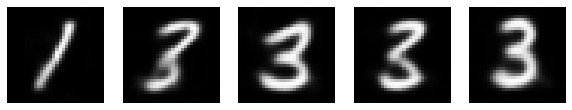

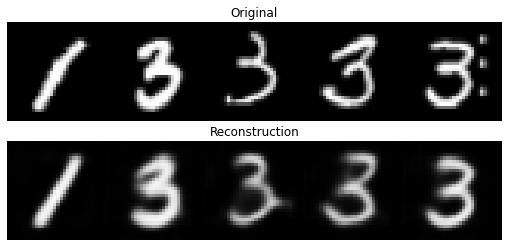

Epoch:    30/100 - Loss: 24.6054 - Recon Loss: 15.0061 - KL Loss: 9.5993: 100%|██████████| 28/28 [00:03<00:00,  8.81it/s]


saved checkpoint


Epoch:    31/100 - Loss: 24.6221 - Recon Loss: 14.7908 - KL Loss: 9.8314: 100%|██████████| 28/28 [00:02<00:00, 10.57it/s] 
Epoch:    32/100 - Loss: 24.1600 - Recon Loss: 14.4334 - KL Loss: 9.7266: 100%|██████████| 28/28 [00:02<00:00, 11.13it/s]
Epoch:    33/100 - Loss: 24.2637 - Recon Loss: 14.4354 - KL Loss: 9.8283: 100%|██████████| 28/28 [00:02<00:00, 10.95it/s] 
Epoch:    34/100 - Loss: 24.3197 - Recon Loss: 14.4954 - KL Loss: 9.8242: 100%|██████████| 28/28 [00:02<00:00, 11.05it/s]
Epoch:    35/100 - Loss: 23.1831 - Recon Loss: 13.4900 - KL Loss: 9.6931: 100%|██████████| 28/28 [00:02<00:00, 11.05it/s]
Epoch:    36/100 - Loss: 23.4773 - Recon Loss: 13.5830 - KL Loss: 9.8943: 100%|██████████| 28/28 [00:02<00:00, 11.22it/s]
Epoch:    37/100 - Loss: 23.1338 - Recon Loss: 13.2569 - KL Loss: 9.8769: 100%|██████████| 28/28 [00:02<00:00, 11.16it/s]
Epoch:    38/100 - Loss: 23.2385 - Recon Loss: 13.4710 - KL Loss: 9.7675: 100%|██████████| 28/28 [00:02<00:00, 11.32it/s]
Epoch:    39/100 - Los

KeyboardInterrupt: 

In [7]:
from models.rvae import RVAE
from models.vae import VAE
from models.dvae import DVAE

def parse_blocks_str(s):
    blocks = []
    for block in s.split(','):
        if 'x' in block:
            res, num = block.split('x')
            blocks.extend([(int(res), None) for _ in range(int(num))])
        elif 'd' in block:
            res, down_rate = block.split('d')
            blocks.append((int(res), int(down_rate)))
        elif 'u' in block:
            res, up_rate = block.split('u')
            blocks.append((int(res), int(up_rate)))
    return blocks

enc_blocks = "32x2,32d2,16x2,16d2,8x2,8d2,4x1"
dec_blocks = "4x1,4u2,8x2,8u2,16x2,16u2,32x2"
ENC_BLOCKS = parse_blocks_str(enc_blocks)
DEC_BLOCKS = parse_blocks_str(dec_blocks)


# model = VAE(IN_CHANNELS, IN_CHANNELS, NUM_CHANNELS, LATENT_DIM, ENC_BLOCKS, DEC_BLOCKS, BOTTLENECK_RATIO).to(device)
model = DVAE(IN_CHANNELS, IN_CHANNELS, LATENT_DIM, NUM_CHANNELS, enc_blocks, dec_blocks, BOTTLENECK_RATIO, riemannian=False, dt=0.1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = torch.utils.data.DataLoader(IdentityDataset(train_x, transform=T.Resize([32, 32])), batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(IdentityDataset(test_x, transform=T.Resize([32, 32])), batch_size=1, shuffle=False)

kwargs = {'dt': 0.1}

model, train_loss_history = train_loop(model, optimizer, EPOCHS, train_loader, **kwargs)
_ = evaluate_model(model, test_loader, **kwargs)
sample_and_save(model, dt=1.)



In [8]:
_ = evaluate_model(model, test_loader, **kwargs)

--------------------------------------------
Test metrics (on test set)


100%|██████████| 100/100 [00:01<00:00, 67.59it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor